reference: https://www.kaggle.com/code/alexisbcook/interactive-maps

In [1]:
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

In [2]:
# Create a map
m_1 = folium.Map(location=[42.32,-71.0589], tiles='openstreetmap', zoom_start=10)

# Display the map
m_1

reference: https://www.kaggle.com/code/alexisbcook/proximity-analysis

In [3]:
import geopandas as gpd

In [4]:
releases = gpd.read_file("./toxic_release_pennsylvania/toxic_release_pennsylvania.shp") 
releases.head()

,YEAR,CITY,COUNTY,ST,LATITUDE,LONGITUDE,CHEMICAL,UNIT_OF_ME,TOTAL_RELE,geometry
0,2016,PHILADELPHIA,PHILADELPHIA,PA,40.005901,-75.072103,FORMIC ACID,Pounds,0.160,POINT (2718560.227 256380.179)
1,2016,PHILADELPHIA,PHILADELPHIA,PA,39.920120,-75.146410,ETHYLENE GLYCOL,Pounds,13353.480,POINT (2698674.606 224522.905)
2,2016,PHILADELPHIA,PHILADELPHIA,PA,40.023880,-75.220450,CERTAIN GLYCOL ETHERS,Pounds,104.135,POINT (2676833.394 261701.856)
3,2016,PHILADELPHIA,PHILADELPHIA,PA,39.913540,-75.198890,LEAD COMPOUNDS,Pounds,1730.280,POINT (2684030.004 221697.388)
4,2016,PHILADELPHIA,PHILADELPHIA,PA,39.913540,-75.198890,BENZENE,Pounds,39863.290,POINT (2684030.004 221697.388)


In [5]:
len(releases)

4663

In [6]:
stations = gpd.read_file("./PhillyHealth_Air_Monitoring_Stations/PhillyHealth_Air_Monitoring_Stations.shp")
stations.head()

,SITE_NAME,ADDRESS,BLACK_CARB,ULTRAFINE_,CO,SO2,OZONE,NO2,NOY_NO,PM10,...,PAMS_VOC,TSP_11101,TSP_METALS,TSP_LEAD,TOXICS_TO1,MET,COMMUNITY_,LATITUDE,LONGITUDE,geometry
0,LAB,1501 East Lycoming Avenue,N,N,Y,N,Y,Y,Y,N,...,Y,N,Y,N,y,N,N,40.008606,-75.097624,POINT (2711384.641 257149.310)
1,ROX,Eva and Dearnley Streets,N,N,N,N,N,N,N,N,...,N,N,Y,N,Y,N,N,40.050461,-75.236966,POINT (2671934.290 271248.900)
2,NEA,Grant Avenue and Ashton Street,N,N,N,N,Y,N,N,N,...,N,N,N,N,N,Y,N,40.072073,-75.013128,POINT (2734326.638 280980.247)
3,CHS,500 South Broad Street,N,N,N,N,N,N,N,N,...,N,N,Y,N,Y,N,N,39.944510,-75.165442,POINT (2693078.580 233247.101)
4,NEW,2861 Lewis Street,N,N,Y,Y,Y,N,Y,Y,...,N,Y,N,Y,N,Y,N,39.991688,-75.080378,POINT (2716399.773 251134.976)


note: To measure distances between points from two different GeoDataFrames, we first have to make sure that they use the same coordinate reference system (CRS)

In [7]:
print(stations.crs)
print(releases.crs)

EPSG:2272
EPSG:2272


In [8]:
len(stations), len(releases)

(12, 4663)

In [9]:
# Select one release incident in particular
recent_release = releases.iloc[360]

# Measure distance from release to each station
distances = stations.geometry.distance(recent_release.geometry)
distances

0     44778.509761
1     51006.456589
2     77744.509207
3     14672.170878
4     43753.554393
5      4711.658655
6     23197.430858
7     12072.823097
8     79081.825506
9      3780.623591
10    27577.474903
11    19818.381002
dtype: float64

In [10]:
print('Mean distance to monitoring stations: {} feet'.format(distances.mean()))

Mean distance to monitoring stations: 33516.28487007786 feet


In [11]:
print('Closest monitoring station ({} feet):'.format(distances.min()))
print(stations.iloc[distances.idxmin()][["ADDRESS", "LATITUDE", "LONGITUDE"]])

Closest monitoring station (3780.623590556444 feet):
ADDRESS      3100 Penrose Ferry Road
LATITUDE                    39.91279
LONGITUDE                 -75.185448
Name: 9, dtype: object


## The **buffer of a geometry** is defined as the Minkowski sum (or difference, for negative distance) of the geometry with a circle with radius equal to the absolute value of the buffer distance. 

In [12]:
#  2 miles (or, 2*5280 feet) 
two_mile_buffer = stations.geometry.buffer(2*5280)
two_mile_buffer.head()

0    POLYGON ((2721944.641 257149.310, 2721893.792 ...
1    POLYGON ((2682494.290 271248.900, 2682443.441 ...
2    POLYGON ((2744886.638 280980.247, 2744835.789 ...
3    POLYGON ((2703638.580 233247.101, 2703587.731 ...
4    POLYGON ((2726959.773 251134.976, 2726908.924 ...
dtype: geometry

In [13]:
# Create map with release incidents and monitoring stations
m = folium.Map(location=[39.9526,-75.1652], zoom_start=11)
HeatMap(data=releases[['LATITUDE', 'LONGITUDE']], radius=15).add_to(m)
for idx, row in stations.iterrows():
    Marker([row['LATITUDE'], row['LONGITUDE']]).add_to(m)
    
# Plot each polygon on the map
folium.GeoJson(two_mile_buffer.to_crs(epsg=4326)).add_to(m)

# Show the map
m

Type: <class 'shapely.geometry.multipolygon.MultiPolygon'>


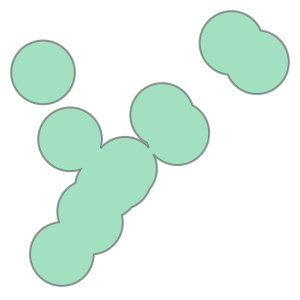

In [18]:
# Turn group of polygons into single multipolygon
my_union = two_mile_buffer.geometry.unary_union
print('Type:', type(my_union))

# Show the MultiPolygon object
my_union

In [19]:
type(two_mile_buffer)

geopandas.geoseries.GeoSeries

In [20]:
type(my_union)

shapely.geometry.multipolygon.MultiPolygon

In [21]:
type(two_mile_buffer.geometry)

geopandas.geoseries.GeoSeries

### note: **EPSG:4326**, also known as the WGS84 projection (because it's based on WGS84's ellipsoid), is a coordinate system used in Google Earth and GSP systems

In [22]:
# Create map with release incidents and monitoring stations
m = folium.Map(location=[39.9526,-75.1652], zoom_start=11)
HeatMap(data=releases[['LATITUDE', 'LONGITUDE']], radius=15).add_to(m)
for idx, row in stations.iterrows():
    Marker([row['LATITUDE'], row['LONGITUDE']]).add_to(m)
    
# Plot each polygon on the map
# folium.GeoJson(two_mile_buffer.to_crs(epsg=4326)).add_to(m)
#folium.GeoJson(my_union).add_to(m)
# Show the map
m

In [23]:
# The closest station is less than two miles away
my_union.contains(releases.iloc[360].geometry)

True

## Excercise
https://www.kaggle.com/code/er1czhang/exercise-proximity-analysis/edit

In [ ]:
import math
import geopandas as gpd
import pandas as pd
from shapely.geometry import MultiPolygon

import folium
from folium import Choropleth, Marker
from folium.plugins import HeatMap, MarkerCluster

In [ ]:
# You'll use the `embed_map()` function to visualize your maps.
def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='500px')

In [ ]:
%%time
collisions = gpd.read_file("./NYPD_Motor_Vehicle_Collisions/NYPD_Motor_Vehicle_Collisions.shp")
collisions.head()

In [ ]:
len(collisions)

In [ ]:
collisions.head(3).T

In [ ]:
collisions.columns

In [ ]:
type(collisions['DATE'][0]), collisions['DATE'][0]

In [ ]:
import datetime
import pandas as pd

In [ ]:
# format conversion from string to datetime
collisions['DATE'] = pd.to_datetime(collisions['DATE'], format='%m/%d/%Y') 

In [ ]:
type(collisions['DATE'][0])

In [ ]:
collisions['DATE'][0].year

In [ ]:
collisions['DATE'].min(), collisions['DATE'].max()

In [ ]:
# Create map with NYPD collisions
# location is NYC
m_1 = folium.Map(location=[40.7, -74], zoom_start=11) 

#HeatMap(data=collisions[['LATITUDE', 'LONGITUDE']], radius=15).add_to(m_1)
HeatMap(data=collisions[['LATITUDE', 'LONGITUDE']]).add_to(m_1)

# Show the map
m_1
#embed_map(m_1, "q_1.html")

In [ ]:
# Create map with NYPD collisions
# location is NYC
m_1 = folium.Map(location=[40.7, -74], zoom_start=11) 

HeatMap(data=collisions[['LATITUDE', 'LONGITUDE']], radius=15).add_to(m_1)
#HeatMap(data=collisions[['LATITUDE', 'LONGITUDE']]).add_to(m_1)

# Show the map
m_1
#embed_map(m_1, "q_1.html")

### create maps of different years

In [ ]:
len(collisions[collisions['DATE'].dt.year==2012])

In [ ]:
def by_year(_year):
    _year = int(_year)
    subset = collisions[collisions['DATE'].dt.year==_year]

    # Create map with NYPD collisions by year
    # location is NYC
    m = folium.Map(location=[40.7, -74], zoom_start=11) 
    
    HeatMap(data=subset[['LATITUDE', 'LONGITUDE']], radius=15).add_to(m)
    
    # Show the map
    print('\nYear', _year)
    print('Number of collisions:', len(subset))
    return m

In [ ]:
by_year(2012)

In [ ]:
for i in range(2012, 2020):
    m = by_year(i)
    display(m)

## Hospitals

In [ ]:
%%time
hospitals = gpd.read_file("./nyu_2451_34494/nyu_2451_34494.shp")
hospitals.head()

In [ ]:
hospitals.columns

In [ ]:
len(hospitals)

In [ ]:
# Create map with collisions and hospitals in NYC
m = folium.Map(location=[40.7, -74], zoom_start=11) 
HeatMap(data=collisions[['LATITUDE', 'LONGITUDE']], radius=15).add_to(m)
for idx, row in hospitals.iterrows():
    Marker([row['latitude'], row['longitude']]).add_to(m)

# Show the map
m